# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 30, 11:59PM

### Name: [Matthew Halvorsen]


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [1]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
from tensorflow import keras
import numpy as np

### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
    results = np.zeros((len(y), num_class))
    for i, y in enumerate(y):
        results[i, y] = 1
    return results

x_train_vec = x_train.astype("float32")/255.0
x_test_vec = x_test.astype("float32")/255.0
y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(x_train_vec.shape)
print(x_test_vec.shape)
print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
(50000, 32, 32, 3)
(10000, 32, 32, 3)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [3]:
rand_indices = np.random.permutation(50000)
train_indices = rand_indices[:40000]
val_indices = rand_indices[40000:]

x_valid_vec = x_train[val_indices]
y_valid_vec = y_train_vec[val_indices]

x_train_par_vec = x_train[train_indices]
y_train_par_vec = y_train_vec[train_indices]

print('Shape of x_tr: ' + str(x_train_par_vec.shape))
print('Shape of y_tr: ' + str(y_train_par_vec.shape))
print('Shape of x_val: ' + str(x_valid_vec.shape))
print('Shape of y_val: ' + str(y_valid_vec.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




![](https://drive.google.com/uc?export=view&id=16zjE3yjAmIjn2PLTZsxDTyxVdxHGTdnV)

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [5]:
# Build the model
from keras import models, layers
import keras_tuner as kt
#from tensorflow.keras.optimizers.legacy import RMSprop, Adam, AdamW

def model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(32,(3,3), input_shape=(32,32,3)))
    #model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(2,2))
    #model.add(layers.Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.05)))
    model.add(layers.Conv2D(128, (3,3)))
    #model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    #model.add(layers.Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.05)))
    model.add(layers.Dense(10, activation='softmax'))

    optimizer_choice = hp.Choice('optimizer', ['Adam', 'RMSprop'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling= 'log')

    if optimizer_choice == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(model, objective='val_accuracy', max_trials=15, executions_per_trial=1, directory='tuner_logs', project_name='cnn_hyperparam_tuning')
tuner.search(x_train_par_vec, y_train_par_vec, epochs=10, validation_data=(x_valid_vec, y_valid_vec))

Reloading Tuner from tuner_logs/cnn_hyperparam_tuning/tuner0.json


In [16]:
best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]
best_lr = best_hp.get('learning_rate')
best_optimizer = best_hp.get('optimizer')

#print("Best Dropout 1:", best_hp.get('dropout1'))
#print("Best Dropout 2:", best_hp.get('dropout2'))
print("Best Optimizer:", best_optimizer)
print("Best Learning Rate:", best_lr)
#best_model.compiile(best_optimizer(learning_rate = best_lr), loss= 'categorical_crossentropy', metrics=['accuracy'])

# This will use the best model that has already been pretrained and then continue training for 50 epochs
history = best_model.fit(x_train_par_vec,y_train_par_vec, epochs=50, batch_size=64, validation_data=(x_valid_vec, y_valid_vec))

Best Optimizer: RMSprop
Best Learning Rate: 0.0017287371672691568
Epoch 1/50
625/625 [==============================] - 9s 13ms/step - loss: 0.4738 - accuracy: 0.8436 - val_loss: 0.4775 - val_accuracy: 0.8393
Epoch 2/50
625/625 [==============================] - 8s 13ms/step - loss: 0.3630 - accuracy: 0.8798 - val_loss: 0.5831 - val_accuracy: 0.8122
Epoch 3/50
625/625 [==============================] - 8s 13ms/step - loss: 0.2807 - accuracy: 0.9064 - val_loss: 0.6385 - val_accuracy: 0.7931
Epoch 4/50
625/625 [==============================] - 8s 13ms/step - loss: 0.2178 - accuracy: 0.9281 - val_loss: 0.8730 - val_accuracy: 0.7671
Epoch 5/50
625/625 [==============================] - 8s 13ms/step - loss: 0.1733 - accuracy: 0.9433 - val_loss: 0.9558 - val_accuracy: 0.7493
Epoch 6/50
625/625 [==============================] - 8s 13ms/step - loss: 0.1405 - accuracy: 0.9542 - val_loss: 0.7566 - val_accuracy: 0.7855
Epoch 7/50
625/625 [==============================] - 8s 13ms/step - loss: 0

## 3. Plot the training and validation loss curve versus epochs. (5 points)

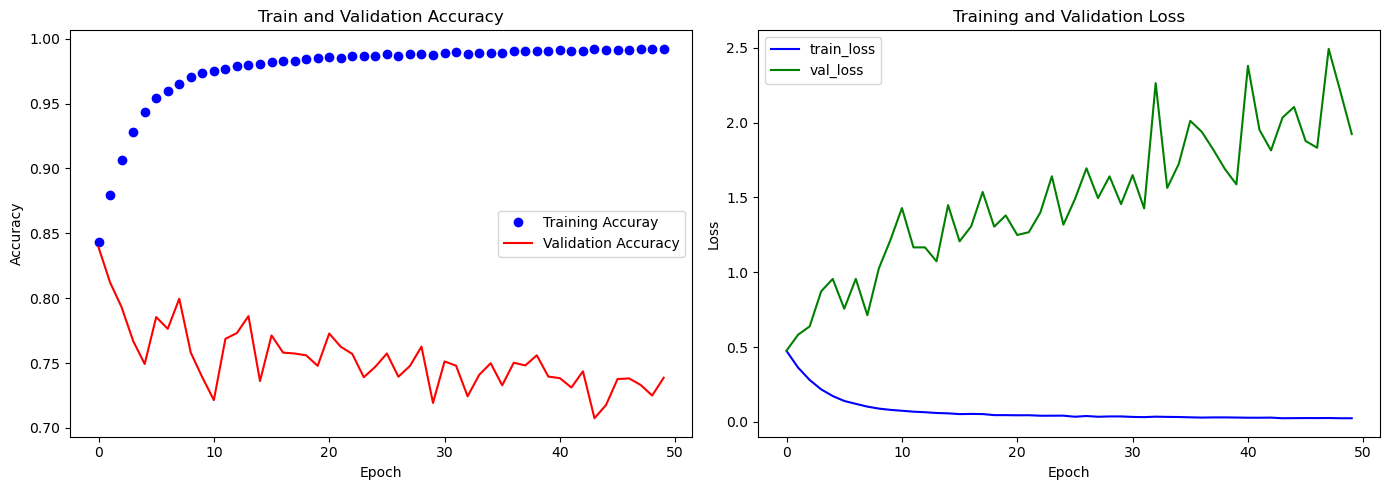

In [17]:
# Plot the loss curve
import matplotlib.pyplot as plt
epochs = range(50)
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'bo', label = 'Training Accuray')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label = 'train_loss')
plt.plot(epochs, val_loss, 'g', label = 'val_loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters.
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [26]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
# This recompiles the model from above and will also use the 50k training samples
# Make a new model with the best hyper parameters to train the model on the same 50k samples
fiftyk_model = model(best_hp)

fiftyk_model.fit(x_train_vec,y_train_vec, epochs=50, batch_size=64, validation_data=(x_valid_vec, y_valid_vec))

Epoch 1/50
782/782 [==============================] - 10s 13ms/step - loss: 1.1735 - accuracy: 0.5858 - val_loss: 1033.9287 - val_accuracy: 0.2496
Epoch 2/50
782/782 [==============================] - 10s 13ms/step - loss: 0.8486 - accuracy: 0.7035 - val_loss: 649.9999 - val_accuracy: 0.2105
Epoch 3/50
782/782 [==============================] - 10s 13ms/step - loss: 0.6904 - accuracy: 0.7597 - val_loss: 202.2671 - val_accuracy: 0.4752
Epoch 4/50
782/782 [==============================] - 10s 13ms/step - loss: 0.5713 - accuracy: 0.8011 - val_loss: 532.0037 - val_accuracy: 0.3480
Epoch 5/50
782/782 [==============================] - 10s 13ms/step - loss: 0.4716 - accuracy: 0.8364 - val_loss: 289.5249 - val_accuracy: 0.4991
Epoch 6/50
782/782 [==============================] - 10s 13ms/step - loss: 0.3904 - accuracy: 0.8646 - val_loss: 357.7696 - val_accuracy: 0.4879
Epoch 7/50
782/782 [==============================] - 10s 13ms/step - loss: 0.3190 - accuracy: 0.8888 - val_loss: 488.4930 

## 5. Evaluate the model on the test set (5 points)

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [27]:
# Evaluate your model performance (testing accuracy) on testing data.
test_loss, test_accuracy = fiftyk_model.evaluate(x_test_vec, y_test_vec, batch_size=64, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

157/157 [==============================] - 1s 5ms/step - loss: 2.2289 - accuracy: 0.6780
Test Loss: 2.2289
Test Accuracy: 0.6780


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...)
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different structures.

In [8]:
# Compare how BN and compare
def model_DR (hp):
    model = models.Sequential()
    model.add(layers.Conv2D(32,(3,3), input_shape=(32,32,3)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.05)))
    model.add(layers.Conv2D(128, (3,3)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.05)))
    model.add(layers.Dense(10, activation='softmax'))

    optimizer_choice = hp.Choice('optimizer', ['Adam', 'RMSprop'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling= 'log')

    if optimizer_choice == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner_DR = kt.BayesianOptimization(model_DR, objective='val_accuracy', max_trials=15, executions_per_trial=1, directory='tuner_logs_DR', project_name='cnn_hyperparam_tuning')
tuner_DR.search(x_train_par_vec, y_train_par_vec, epochs=10, validation_data=(x_valid_vec, y_valid_vec))


Trial 15 Complete [00h 02m 26s]
val_accuracy: 0.09589999914169312

Best val_accuracy So Far: 0.6018000245094299
Total elapsed time: 00h 52m 59s


In [9]:
# Train new model
best_model_DR = tuner_DR.get_best_models(1)[0]
best_hp_DR = tuner_DR.get_best_hyperparameters(1)[0]
best_lr_DR = best_hp_DR.get('learning_rate')
best_optimizer_DR = best_hp_DR.get('optimizer')

print("Best Dropout 1:", best_hp_DR.get('dropout1'))
print("Best Dropout 2:", best_hp_DR.get('dropout2'))
print("Best Optimizer:", best_optimizer_DR)
print("Best Learning Rate:", best_lr_DR)

Dropout_model = model_DR(best_hp_DR)

history_dropout = Dropout_model.fit(x_train_par_vec,y_train_par_vec, epochs=50, batch_size=64, validation_data=(x_valid_vec, y_valid_vec))
# This will use the best model that has already been pretrained and then continue training for 50 epochs
#history_DR = best_model_DR.fit(x_train_par_vec,y_train_par_vec, epochs=50, batch_size=64, validation_data=(x_valid_vec, y_valid_vec))

Best Dropout 1: 0.35000000000000003
Best Dropout 2: 0.2
Best Optimizer: Adam
Best Learning Rate: 0.0013364766389842525
Epoch 1/50
625/625 [==============================] - 10s 15ms/step - loss: 3.0454 - accuracy: 0.2963 - val_loss: 1.6147 - val_accuracy: 0.4103
Epoch 2/50
625/625 [==============================] - 10s 15ms/step - loss: 1.5952 - accuracy: 0.4174 - val_loss: 1.4955 - val_accuracy: 0.4521
Epoch 3/50
625/625 [==============================] - 10s 15ms/step - loss: 1.4647 - accuracy: 0.4735 - val_loss: 1.3718 - val_accuracy: 0.5058
Epoch 4/50
625/625 [==============================] - 9s 15ms/step - loss: 1.3759 - accuracy: 0.5108 - val_loss: 1.2938 - val_accuracy: 0.5385
Epoch 5/50
625/625 [==============================] - 10s 15ms/step - loss: 1.3169 - accuracy: 0.5377 - val_loss: 1.2355 - val_accuracy: 0.5678
Epoch 6/50
625/625 [==============================] - 9s 15ms/step - loss: 1.2475 - accuracy: 0.5621 - val_loss: 1.1833 - val_accuracy: 0.5820
Epoch 7/50
625/625 

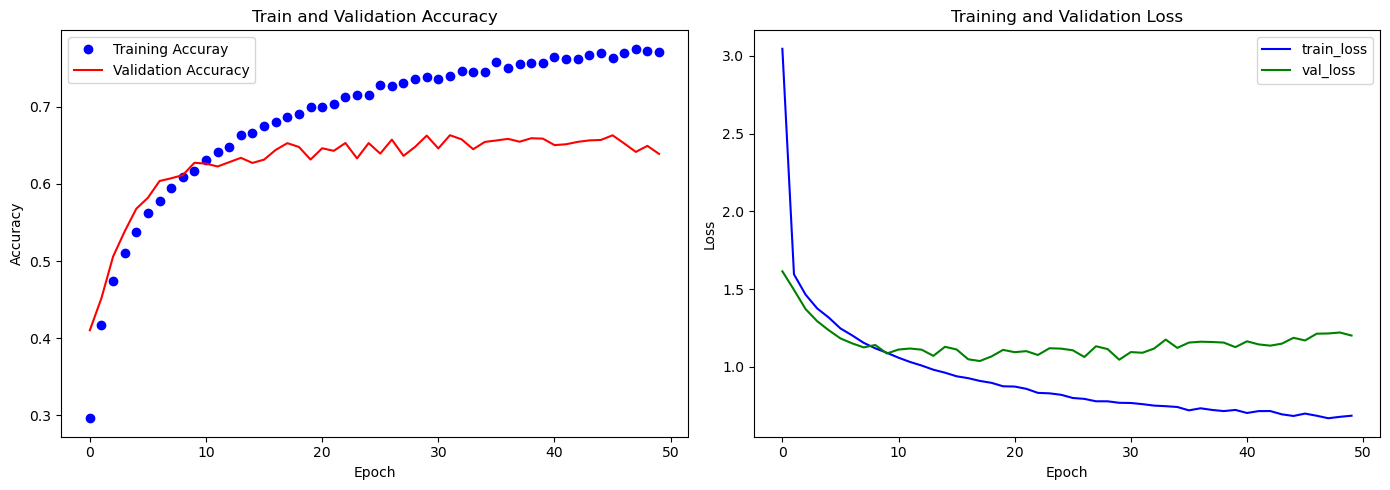

In [13]:
# Evaluate New Model
epochs = range(50)
train_accuracy_DR = history_dropout.history['accuracy']
val_accuracy_DR = history_dropout.history['val_accuracy']
train_loss_DR = history_dropout.history['loss']
val_loss_DR = history_dropout.history['val_loss']

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy_DR, 'bo', label = 'Training Accuray')
plt.plot(epochs, val_accuracy_DR, 'r', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_loss_DR, 'b', label = 'train_loss')
plt.plot(epochs, val_loss_DR, 'g', label = 'val_loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# 2nd model test accuracy

test_loss_DR, test_accuracy_DR = Dropout_model.evaluate(x_test_vec, y_test_vec, batch_size=64, verbose=1)
print(f"Test Loss: {test_loss_DR:.4f}")
print(f"Test Accuracy: {test_accuracy_DR:.4f}")

157/157 [==============================] - 1s 6ms/step - loss: 3.0021 - accuracy: 0.1061
Test Loss: 3.0021
Test Accuracy: 0.1061


In [36]:
# 3rd model, batch normaliztion added
def model_DR_BN (hp):
    model = models.Sequential()
    model.add(layers.Conv2D(32,(3,3), input_shape=(32,32,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.05)))
    model.add(layers.Conv2D(128, (3,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.05)))
    model.add(layers.Dense(10, activation='softmax'))

    optimizer_choice = hp.Choice('optimizer', ['Adam', 'RMSprop'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling= 'log')

    if optimizer_choice == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner_DR_BN = kt.BayesianOptimization(model_DR_BN, objective='val_accuracy', max_trials=15, executions_per_trial=1, directory='tuner_logs_DR_BN', project_name='cnn_hyperparam_tuning')
tuner_DR_BN.search(x_train_par_vec, y_train_par_vec, epochs=10, validation_data=(x_valid_vec, y_valid_vec))

Trial 15 Complete [00h 03m 13s]
val_accuracy: 0.7117000222206116

Best val_accuracy So Far: 0.7199000120162964
Total elapsed time: 00h 49m 04s


In [48]:
# Train 3rd model
best_model_DR_BN = tuner_DR_BN.get_best_models(1)[0]
best_hp_DR_BN = tuner_DR_BN.get_best_hyperparameters(1)[0]
best_lr_DR_BN = best_hp_DR_BN.get('learning_rate')
best_optimizer_DR_BN = best_hp_DR_BN.get('optimizer')

print("Best Dropout 1:", best_hp_DR_BN.get('dropout1'))
print("Best Dropout 2:", best_hp_DR_BN.get('dropout2'))
print("Best Optimizer:", best_optimizer_DR_BN)
print("Best Learning Rate:", best_lr_DR_BN)

DR_BN_model = model_DR_BN(best_hp_DR_BN)
# This will use the best model that has already been pretrained and then continue training for 50 epochs
history_DR_BN = DR_BN_model.fit(x_train_par_vec,y_train_par_vec, epochs=50, batch_size=64, validation_data=(x_valid_vec, y_valid_vec))

Best Dropout 1: 0.2
Best Dropout 2: 0.25
Best Optimizer: RMSprop
Best Learning Rate: 0.0004703116290931317
Epoch 1/50
625/625 [==============================] - 12s 19ms/step - loss: 1.4069 - accuracy: 0.5022 - val_loss: 1.3029 - val_accuracy: 0.5259
Epoch 2/50
625/625 [==============================] - 12s 19ms/step - loss: 1.0721 - accuracy: 0.6262 - val_loss: 1.0613 - val_accuracy: 0.6254
Epoch 3/50
625/625 [==============================] - 11s 18ms/step - loss: 0.9472 - accuracy: 0.6661 - val_loss: 1.4150 - val_accuracy: 0.5333
Epoch 4/50
625/625 [==============================] - 11s 18ms/step - loss: 0.8573 - accuracy: 0.6990 - val_loss: 1.0161 - val_accuracy: 0.6417
Epoch 5/50
625/625 [==============================] - 11s 18ms/step - loss: 0.7937 - accuracy: 0.7242 - val_loss: 0.9432 - val_accuracy: 0.6672
Epoch 6/50
625/625 [==============================] - 11s 18ms/step - loss: 0.7330 - accuracy: 0.7454 - val_loss: 1.0775 - val_accuracy: 0.6221
Epoch 7/50
625/625 [=========

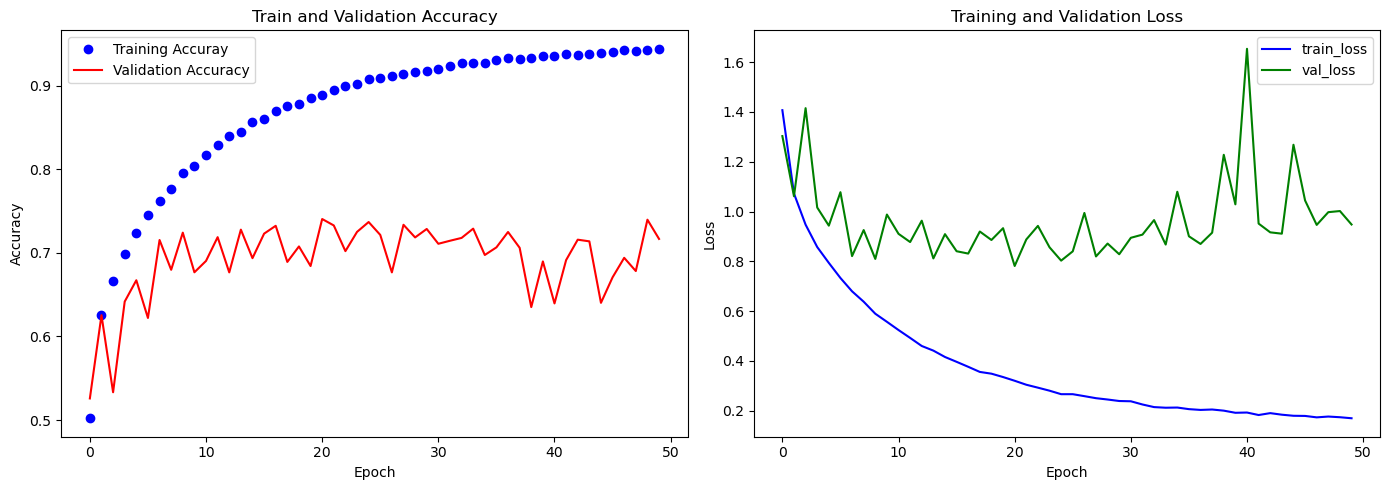

In [49]:
# Evaluate new model
epochs = range(50)
train_accuracy_DR_BN = history_DR_BN.history['accuracy']
val_accuracy_DR_BN = history_DR_BN.history['val_accuracy']
train_loss_DR_BN = history_DR_BN.history['loss']
val_loss_DR_BN = history_DR_BN.history['val_loss']

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy_DR_BN, 'bo', label = 'Training Accuray')
plt.plot(epochs, val_accuracy_DR_BN, 'r', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_loss_DR_BN, 'b', label = 'train_loss')
plt.plot(epochs, val_loss_DR_BN, 'g', label = 'val_loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
# 3rd model accuracy
test_loss_DR_BN, test_accuracy_DR_BN = DR_BN_model.evaluate(x_test_vec, y_test_vec, batch_size=64, verbose=1)
print(f"Test Loss: {test_loss_DR_BN:.4f}")
print(f"Test Accuracy: {test_accuracy_DR_BN:.4f}")

157/157 [==============================] - 1s 6ms/step - loss: 3.7566 - accuracy: 0.1000
Test Loss: 3.7566
Test Accuracy: 0.1000


When comparing the 3 models we can see that a CNN without any dropout or batch normalization there is some overfitting occurring. The training accuracy increases and the validation accuracy starts off high but decreases over time. When 2 dropout layers are added into the code for the second version of the model, we can both the validation and training accuracy are not as high as the first model as they both hover between 0.7 - 0.77 at there max. More epochs may improve this but this may also lead to overfitting as the validation accuracy does not seem to increase significantly. The final model which includes both batch normalization and dropout layers seems to overfit relativatley quickly. This may be due to too much normaization in the model. A more balanced architecture with less batch normalization and dropout may be the ideal scenario to fix overfitting and give a desirable test, validation, and train accuracy.